# **Statistics Lab 52568 - Lab 4 Solution**

First, we read the 2021 Israeli election results, and extract the parties voting data

In [3]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
from matplotlib import pyplot as plt
import random
import statsmodels.api as sm
import io

First, we need to mount our local drive to the colab network

In [4]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


In [5]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "C:/Users/Or Zuk/Google Drive/HUJI/Teaching/Lab_52568/Data/Elections/"  


Mounted at /content/drive


In [6]:
# Loading elections 2021 data - ballot:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving votes per city 2021.csv to votes per city 2021.csv
Saving votes per ballot 2021.csv to votes per ballot 2021.csv


In [ ]:
# Loading demographics data - eshkol hebrati calcali:
if run_in_colab:
    from google.colab import files
    socio = files.upload()

Saving eshkol_hevrati_calcali.csv to eshkol_hevrati_calcali.csv
Saving eshkol_hevrati_calcali.xlsx to eshkol_hevrati_calcali.xlsx


In [8]:
# Loading elections 2021 elections data:
import io

data_type = "city" # "ballot"  # city
if run_in_colab:
    if data_type == "ballot":
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
      df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:  # read local file
    if data_type == "ballot":
        df_2021_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
    else:
        df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')

if data_type == "ballot":
    # preprocessing of ballot
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[8:-1]] # removing "metadata" columns
else:
    # preprocessing of cities 
    df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
    df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe

# convert columns with the parties' names:
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}

df_2021.rename(columns=parties_dict_2021, inplace=True)

In [9]:
# df_2021.reset_index(inplace=True)
df_2021.style.set_properties(**{'text-align': 'left'})
df_2021.head()

,עבודה,ימינה,יהדות התורה,הרשימה המשותפת,ז,זץ,הציונות הדתית,י,יז,ינ,יף,יק,יר,כ,כך,כחול לבן,ישראל ביתנו,הליכוד,מרצ,נ,ני,נר,רעם,יש עתיד,ףז,צי,צכ,צף,ץ,ק,קי,קך,קץ,ר,רנ,רף,רק,שס,תקוה חדשה
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבירים,47,0,0,3,0,0,2,0,3,0,0,0,0,0,0,16,2,5,31,0,0,0,0,27,0,0,0,0,0,0,0,0,0,5,0,0,0,1,8
אדירים,1,7,4,0,0,0,9,0,1,0,0,0,0,0,0,3,0,84,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,61,6
אושה,72,7,0,3,0,0,0,0,2,0,0,1,0,0,0,37,8,24,20,0,0,0,0,86,0,0,0,0,0,0,0,0,0,1,0,0,0,0,15
אחווה,14,4,0,0,0,0,4,0,0,0,0,0,0,0,0,36,3,27,10,0,0,0,0,37,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8
איבים,0,4,0,0,0,1,10,0,0,0,0,0,0,0,0,5,0,17,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


We use only the parties which their voting **percentage** 
in a given city is above a % threshold, and we remove the results of 'Maatafot hitzoniot':

In [10]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.035)  # total votes for each party
names = total_votes.keys() # largest parties

# Data with only the largest parties:
df_2021 = df_2021[names]
df_2021 = df_2021.drop('מעטפות חיצוניות')
df_2021_raw = df_2021_raw.drop('מעטפות חיצוניות')

## Question 1: 

#### Function that calculates the new fixing parameter  $\alpha$ , and fixes the given data.




In [11]:
# Correct for voting turnout in cities/ballots using linear regression
def regression_turnout_correction(df, turnout):
    # Preprocess: remove cities/ballots with zero votes:
    good_inds = np.where(np.array(turnout) > 0)
    if np.min(turnout) == 0:
      print("Removed cities with no votes in simulation")
    df = df.iloc[good_inds]
    turnout = turnout.iloc[good_inds]

    p = df.sum().div(df.sum().sum())  # votes without correction
    bzb = df.sum(axis=1) / turnout # can also be read from outside
    model = sm.OLS(bzb, df).fit() # linear regression WITHOUT intercept
    q_hat = p * model.params  # M.coef_ # beta_inv
    q_hat = q_hat / q_hat.sum()  # Normalize
    return p, q_hat, model.params # beta_inv

## Question 2: 
#### Repeat the simulations same as in lab 3, and add to the graphs the estimator with the new fixing parameter




From lab 3: 
Function that recieves the  $\tilde{N}$ and V matrices and samples binomial votes.

In [12]:
def sim_data(N,V):
  new_df = pd.DataFrame(np.random.binomial(N,V))
  new_df.index = df_2021.index
  v = new_df.sum(axis=1)/ N.sum(axis=1)
  return new_df, v

#### Run simulations and apply corrections

Computing  $\tilde{N}$ and $V_i$ for the 3 simulations:

In [20]:
# Nij~ :
N_tilde = np.array(df_2021.mul(df_2021_raw['בזב'].sum()).div(df_2021_raw['כשרים'].sum()),dtype='int32')

# 3 types of Vi 
v = df_2021_raw['כשרים'].div(df_2021_raw['בזב'])
u = list(np.random.permutation(0.2 + np.array(range(13)) * 0.05))
#u = [0.6,0.65,0.75,0.5,0.4,0.35,0.8,0.55,0.45,0.25,0.3,0.7,0.2]
#u_random = random.sample(u, len(u))

dim = df_2021.shape
# converting them to the desired shape:
V_v = np.tile(np.array([v]).transpose(), (1, len(names)))
V_u = np.tile(np.array(u), (dim[0],1))
#V_u_random = np.tile(np.array(u_random), (dim[0],1))

V_u_random = V_u.copy()
for i in range(df_2021.shape[0]):
  V_u_random[i,] = np.random.permutation(u)
#V_u_random = np.tile(np.array(u_random), (dim[0],1))

A function that calculates the $p$ and the  $\hat{q}$  (after fixing data to 100% votes with $v_i= \frac{kosher_i}{bzb_i}$)

In [22]:
def turnout_correction(df, fix_param):
  p = parties_votes_percents(df, 0) 
  q_hat = parties_votes_percents(df.div(fix_param, axis = "rows"), 0)
  return q_hat


Multiple simulations function:

In [23]:
def simulations(iters,N,V):
  p_mat = np.zeros([iters, len(names)])
  q_hat = np.zeros([iters, len(names)]) 
  q_hat_reg = np.zeros([iters, len(names)]) 

  # in every simulation we calculate p and q_hat (after fixing the data)
  for i in range(0,iters):
    new_df, v = sim_data(N,V)
    q_hat[i,] = turnout_correction(new_df, v)
    p_mat[i,], q_hat_reg[i,] = regression_turnout_correction(new_df, v)[0:2]

  return p_mat, q_hat, q_hat_reg

 Run 50 simulations:

In [24]:
iters = 50 # number of simulations
q_real = N_tilde.sum(axis=0)/(N_tilde.sum())

sim_v = simulations(iters, N_tilde, V_v)
mean_p_v = np.nanmean(sim_v[0],axis=0)
mean_q_v = np.nanmean(sim_v[1],axis=0)
mean_q_v_beta = np.nanmean(sim_v[2],axis=0)
std_q_v = np.std(sim_v[1],axis=0) # Compute also standard deviations 
std_q_v_beta = np.std(sim_v[2],axis=0)

sim_u = simulations(iters, N_tilde, V_u)
mean_p_u = sim_u[0].mean(axis=0) 
mean_q_u = sim_u[1].mean(axis=0) 
mean_q_u_beta = sim_u[2].mean(axis=0)
std_q_u = sim_u[1].std(axis=0) 
std_q_u_beta = sim_u[2].std(axis=0)

sim_u_random = simulations(iters, N_tilde, V_u_random)
mean_p_u_random = sim_u_random[0].mean(axis=0)
mean_q_u_random = sim_u_random[1].mean(axis=0)
mean_q_u_random_beta = sim_u_random[2].mean(axis=0)
std_q_u_random = sim_u_random[1].std(axis=0)
std_q_u_random_beta = sim_u_random[2].std(axis=0)



Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation
Removed cities with no votes in simulation


## Bar-plots showing the results

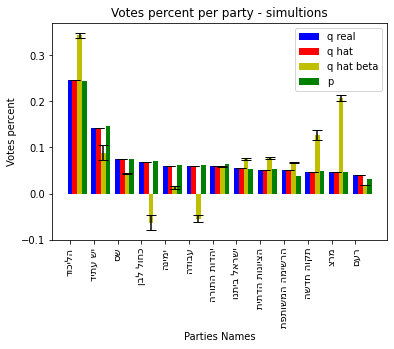

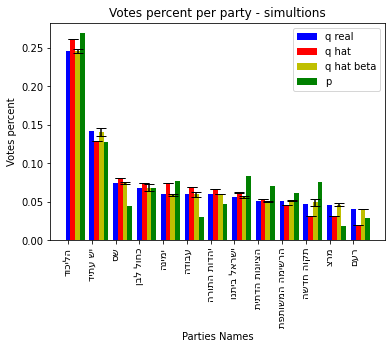

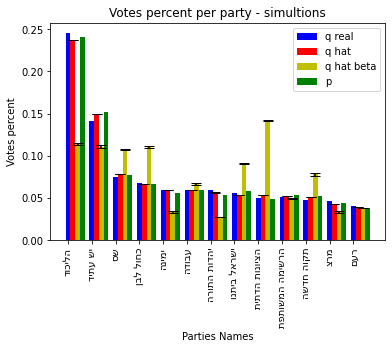

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb82ee34d10>)

In [25]:
# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar_fix(q_real, q_hat, q_hat_beta, q_hat_std, q_hat_beta_std, p):
    width = 0.2  # set column width 
    n = len(total_votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots()  # plt.subplots()

    q_real_bar = ax.bar(np.arange(n), list(q_real), width, color='b')
    q_hat_bar = ax.bar(np.arange(n)+width, q_hat, width, color='r', yerr = q_hat_std, capsize=5)
    q_hat_beta_bar = ax.bar(np.arange(n)+2*width, q_hat_beta, width, color='y', yerr = q_hat_beta_std, capsize=5)
    p_bar = ax.bar(np.arange(n)+3*width, p, width, color='g')

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party - simultions')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation=90)
    ax.legend((q_real_bar, q_hat_bar, q_hat_beta_bar, p_bar), ('q real', 'q hat', 'q hat beta', 'p'))
    plt.show()

    return fig, ax

party_bar_fix(q_real, mean_q_v, mean_q_v_beta, std_q_v, std_q_v_beta, mean_p_v)
party_bar_fix(q_real, mean_q_u, mean_q_u_beta, std_q_u, std_q_u_beta, mean_p_u)
party_bar_fix(q_real, mean_q_u_random, mean_q_u_random_beta, std_q_u_random, std_q_u_random_beta, mean_p_u_random)

## Question 3: Socio-economic data

Loading eshkol hevrati data and votes per city

In [ ]:
if  run_in_colab:
    df_city_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_socio = pd.read_excel(io.BytesIO(socio['eshkol_hevrati_calcali.xlsx']), index_col='name')
else:
    df_city_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
    df_socio = pd.read_excel('eshkol_hevrati_calcali.xlsx', index_col='name')

# preprocessing of cities 
df_city = df_city_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_city = df_city[df_city.columns[5:-1]] # removing "metadata" columns
df_city['סמל ישוב'] = df_city_raw['סמל ישוב']

df_city.rename(columns=parties_dict_2021, inplace=True)

df_socio.head(5)

,set_code,population,index_value,eco_level
name,,,,
עוזייר,528,3047.0,-1.679,1
רומאנה,539,1129.0,-1.566,2
רומת הייב,997,1882.0,-1.237,2
חמאם,993,1410.0,-0.738,3
תרבין א-צאנע (יישוב),1346,437.0,-3.103,1


Finding the shared cities in the two dataframes

In [ ]:
# Create a merged data frame by using the pandas join commend:
merged_df = df_city.join(df_socio.set_index('set_code'), on='סמל ישוב')
merged_df = merged_df.dropna()
print("The number of shared cities is: " + str(merged_df.shape[0]))

num_not_shared = df_city.shape[0] - merged_df.shape[0]
print("The number of not shared cities: " + str(num_not_shared))


The number of shared cities is: 1171
The number of not shared cities: 44


Creating new dataframe with only the shared cities

In [ ]:
# Compute and plot voting frequencies in all shared cities, vs. all of Israel
df_socio_city = merged_df[names]
p_shared = df_socio_city.sum().div(df_socio_city.sum().sum())
p_all = df_city[names].sum().div(df_city[names].sum().sum())



Plotting the votes share for the 13 biggest parties in the shared dataframe vs. the regular (with all cities):

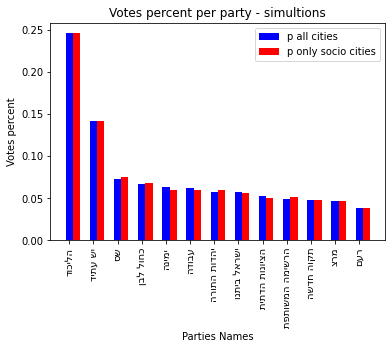

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac823ea590>)

In [ ]:
# Bar plot for a party, only showing values above a certain threshold after fixing:
def party_bar(p_all, p_socio):
    width = 0.3  # set column width 
    n = len(total_votes)

    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots()  # plt.subplots()

    p_all = ax.bar(np.arange(n), list(p_all), width, color='b')
    p_socio = ax.bar(np.arange(n)+width, p_socio, width, color='r')

    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party - simultions')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names, rotation = 90)
    ax.legend((p_all, p_socio,), ('p all cities', 'p only socio cities'))
    plt.show()

    return fig, ax

party_bar(p_all, p_shared)


## Question 4: different socio-economic votting paterns

In [ ]:
#Compute voting frequencies for each party and each eshkol:
p_dict = {name: [] for name in names}

for eshkol in range(10): # run over each eshkol
  # Find all cities in current eshkol. You can use np.where (similar to R which)
  rel_cities = np.where(merged_df['eco_level'].values.astype('float') == eshkol+1)[0]
  # Compute parties total votes for cities in current eshkol (do not normalize)
  p = merged_df.iloc[rel_cities][names].sum() # .div(merged_df.iloc[rel_cities][names].sum().sum())

  parties = p.keys()
  for i in range(len(names)):
    p_dict[parties[i]].append(p[i])
p_df = pd.DataFrame(p_dict, index=list(range(1, 11)))
p_df.head(10)

,הליכוד,יש עתיד,שס,כחול לבן,ימינה,עבודה,יהדות התורה,ישראל ביתנו,הציונות הדתית,הרשימה המשותפת,תקוה חדשה,מרצ,רעם
1,2996,424,10353,133,200,199,33247,32,3058,8539,364,769,31712
2,74165,17771,87690,10136,22278,11598,138556,8254,40029,70727,11535,13062,55103
3,42500,8222,20635,4628,9320,4886,6682,12087,22164,71983,4942,8653,47487
4,66262,14804,20427,7291,9451,5497,8350,17369,12817,17390,7850,5048,11051
5,190079,48995,48951,21106,33507,13526,19175,60317,31957,11602,26081,8143,1673
6,137909,45157,29511,21152,32071,14836,5722,27687,23922,2074,21654,8735,338
7,251938,160976,46595,73949,61888,56347,16253,58421,37264,11625,55496,35522,648
8,181216,226481,26744,109998,59006,112315,6098,33134,25101,6312,52864,89217,1389
9,15376,31613,1063,16259,6019,14625,521,3305,1749,329,5980,11997,53
10,684,1238,23,667,154,356,12,197,48,13,155,432,5


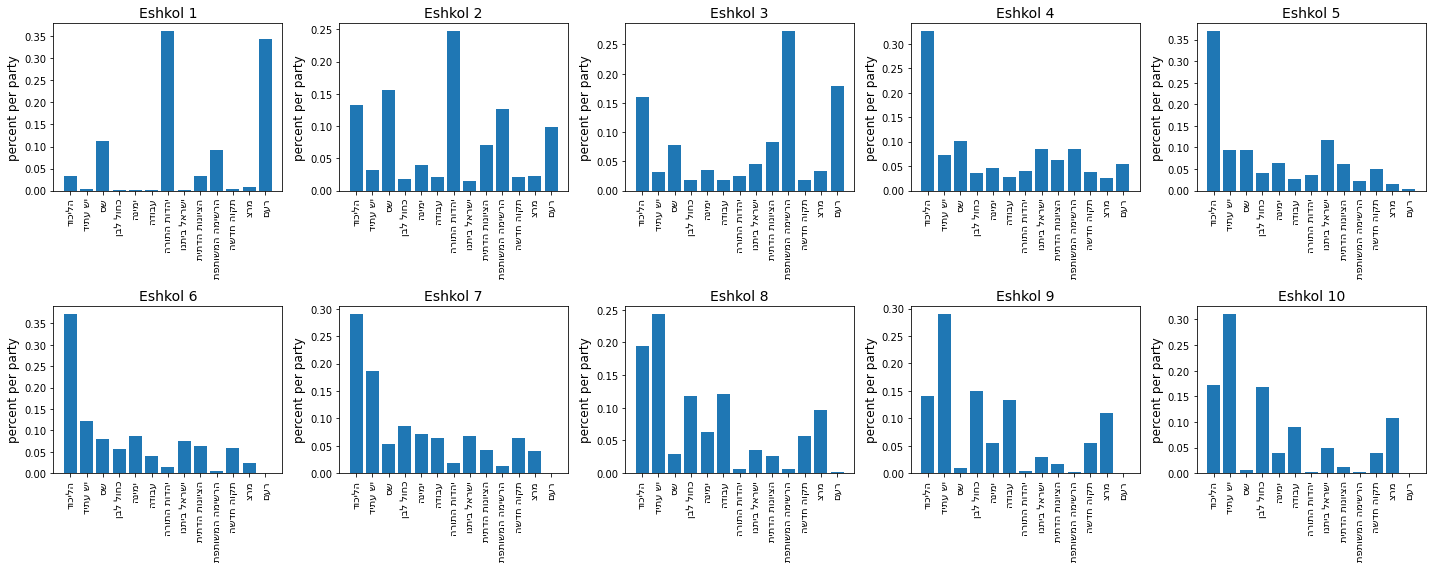

(<Figure size 1440x576 with 10 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac77cbcc90>)

In [ ]:
def votes_percent_by_socio(df):
    fig, ax = plt.subplots(2, 5, figsize=(20,8))
    names_r = [n[::-1] for n in names]

    x = names
    for eshkol in range(10):      
        ax[eshkol//5, eshkol%5].bar(x, df.loc[eshkol+1].div(sum(df.loc[eshkol+1])))
        ax[eshkol//5, eshkol%5].set_title("Eshkol " + str(eshkol+1), fontsize=14)
    for ax in ax.flat:
        ax.set_xticklabels(names_r, rotation=90, fontsize=10)
        ax.set_ylabel('percent per party', fontsize=12)

    fig.tight_layout()     
    plt.show()
    return fig, ax

votes_percent_by_socio(p_df)

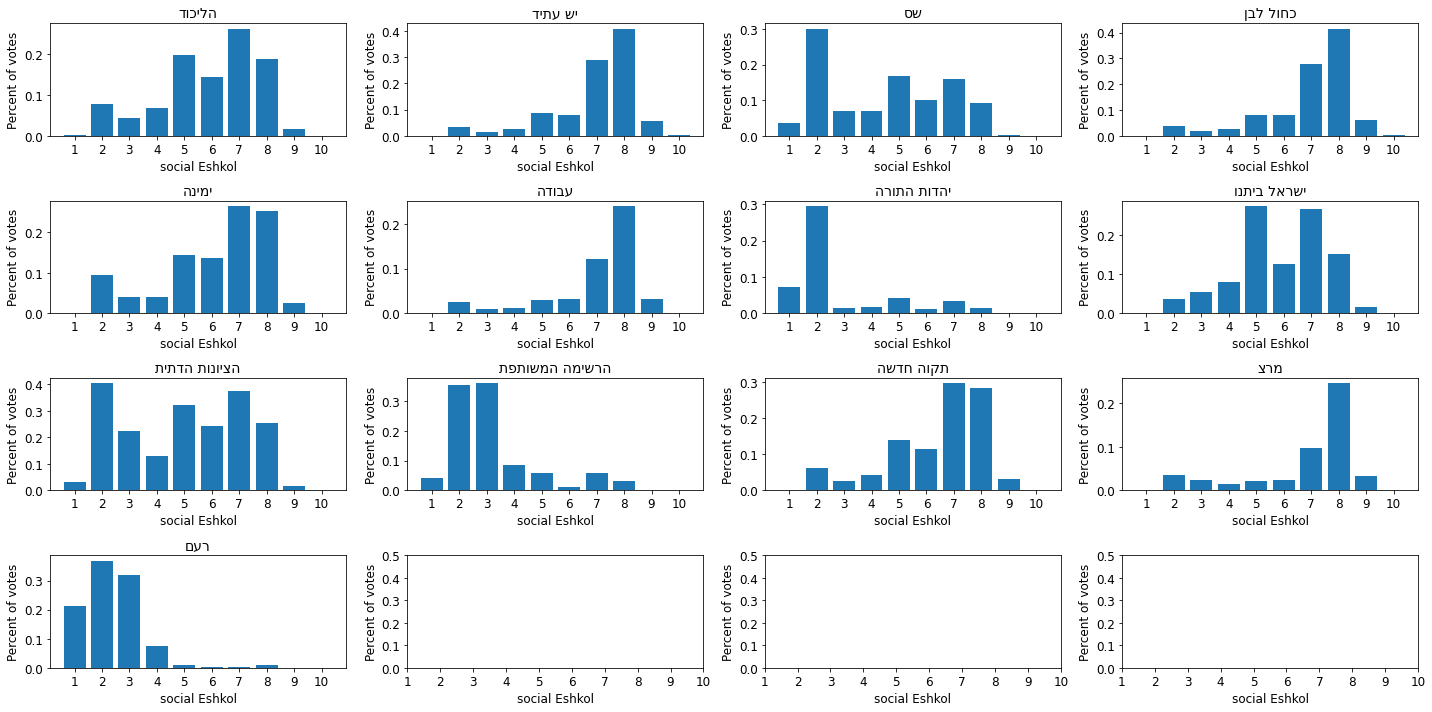

(<Figure size 1440x720 with 16 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fac7757c1d0>)

In [ ]:
# subplots for each party by socio Eshkol
def votes_percent_per_party_socio(df):
    fig, ax = plt.subplots(4, 4, figsize=(20,10))

    n = 10 # number of eshkols
    names_rev = [n[::-1] for n in names]
    for party in range(len(names)):    
        ax[party//4, party%4].bar(np.arange(n), df[names[party]].div(sum(df[names[party]])))
        ax[party//4, party%4].set_title(names_rev[party], fontsize=14)

    y_perc = np.round(np.arange(0,1,0.1),1).tolist()
    for ax in ax.flat:
        ax.set_xticklabels(np.arange(10)+1, fontsize=12)
        ax.xaxis.set_ticks(np.arange(0, 10, 1))
        ax.set_ylabel('Percent of votes', fontsize=12)
        ax.set_xlabel('social Eshkol', fontsize=12)
        ax.set_yticklabels(y_perc, fontsize=12)
    fig.tight_layout() 
    plt.show()
    return fig, ax

p_df_t = pd.DataFrame(np.array(p_df).T, index=p_df.columns)
votes_percent_per_party_socio(p_df)